In [1]:
import os
import sys

if os.getcwd().endswith("notebooks"):
    os.chdir("..")

sys.path.append(os.path.abspath("./"))

print(f"Current work directory: {os.getcwd()}")

Current work directory: C:\Users\yyyyx\Work\OC43_machine_learning\Regression_Modeling_of_OC43_Coronavirus_Viral_Burden_from_Host_Single-cell_Transcriptomes_Using_Explainable_Machine_Learning


In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scripts.plotting as pl
import anndata

C:\Users\yyyyx\miniconda3\envs\scanpy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
adata = sc.read_h5ad('./Data/h5ad/Oc43_adata.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 12980 × 21640
    obs: 'condition', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_oc43', 'pct_counts_oc43', 'viral_fraction', 'viral_per_10k', 'y_log1p_per10k', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'oc43', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [5]:
adata_train  = sc.read_h5ad('./Data/h5ad/train.h5ad')

In [6]:
hvg = adata_train.var_names

In [7]:
index = adata.var_names[~adata.var['oc43']]

In [8]:
adata = adata[:, index].copy()

In [9]:
adata 

AnnData object with n_obs × n_vars = 12980 × 21632
    obs: 'condition', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_oc43', 'pct_counts_oc43', 'viral_fraction', 'viral_per_10k', 'y_log1p_per10k', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'oc43', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [10]:
adata_hvg = adata[:, adata.var_names.isin(hvg)].copy()

In [11]:
sc.tl.pca(adata_hvg, svd_solver='arpack')
sc.pp.neighbors(adata_hvg, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_hvg)
sc.tl.leiden(adata_hvg, resolution=0.1)

C:\Users\yyyyx\AppData\Local\Temp\ipykernel_4836\2115613157.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_hvg, resolution=0.1)


In [12]:
pct = adata_hvg.obs['pct_counts_oc43'].astype(float)
tot = adata_hvg.obs['total_counts_oc43'].astype(float)

# Threshold (adjust if necessary)
p_hi = 10.0 # High infection threshold (%)
eps = 0.1 # No infetion threshold (%)
t_hi = 10 # Upper limit of total_counts for No threshold

# Conditional Mask
no_mask   = ((pct <= eps) | (tot <= t_hi)).fillna(False)
high_mask = ((pct >= p_hi) & (tot > t_hi)).fillna(False)

labels = np.select(
    [no_mask, high_mask],
    ['No infection', 'High infection'],
    default='Low infection'
)

adata_hvg.obs['infection_group'] = pd.Categorical(
    labels,
    categories=['No infection','Low infection','High infection'],
    ordered=True
)

print(adata_hvg.obs['infection_group'].value_counts())

infection_group
No infection      5722
Low infection     4102
High infection    3156
Name: count, dtype: int64


In [13]:
category_colors = {
        'No infection': '#4A90E2',
        'Low infection': '#F5A623',
        'High infection': '#D0021B'
    }
condition_palette = {
    '00h_uninfected': '#1f77b4',  # blue
    '16h_MOI1.0':     '#ff7f0e',  # orange
    '24h_MOI1.0':     '#2ca02c',  # green
    '48h_MOI1.0':     '#d62728'   # red
}

Categorical UMAP saved to: ./Plot/Infection_group.png
Categorical UMAP saved to: ./Plot/Infection_teimcourse.png


(<Figure size 2100x1800 with 1 Axes>,
 <Axes: title={'center': 'Infection Time course'}, xlabel='UMAP1', ylabel='UMAP2'>)

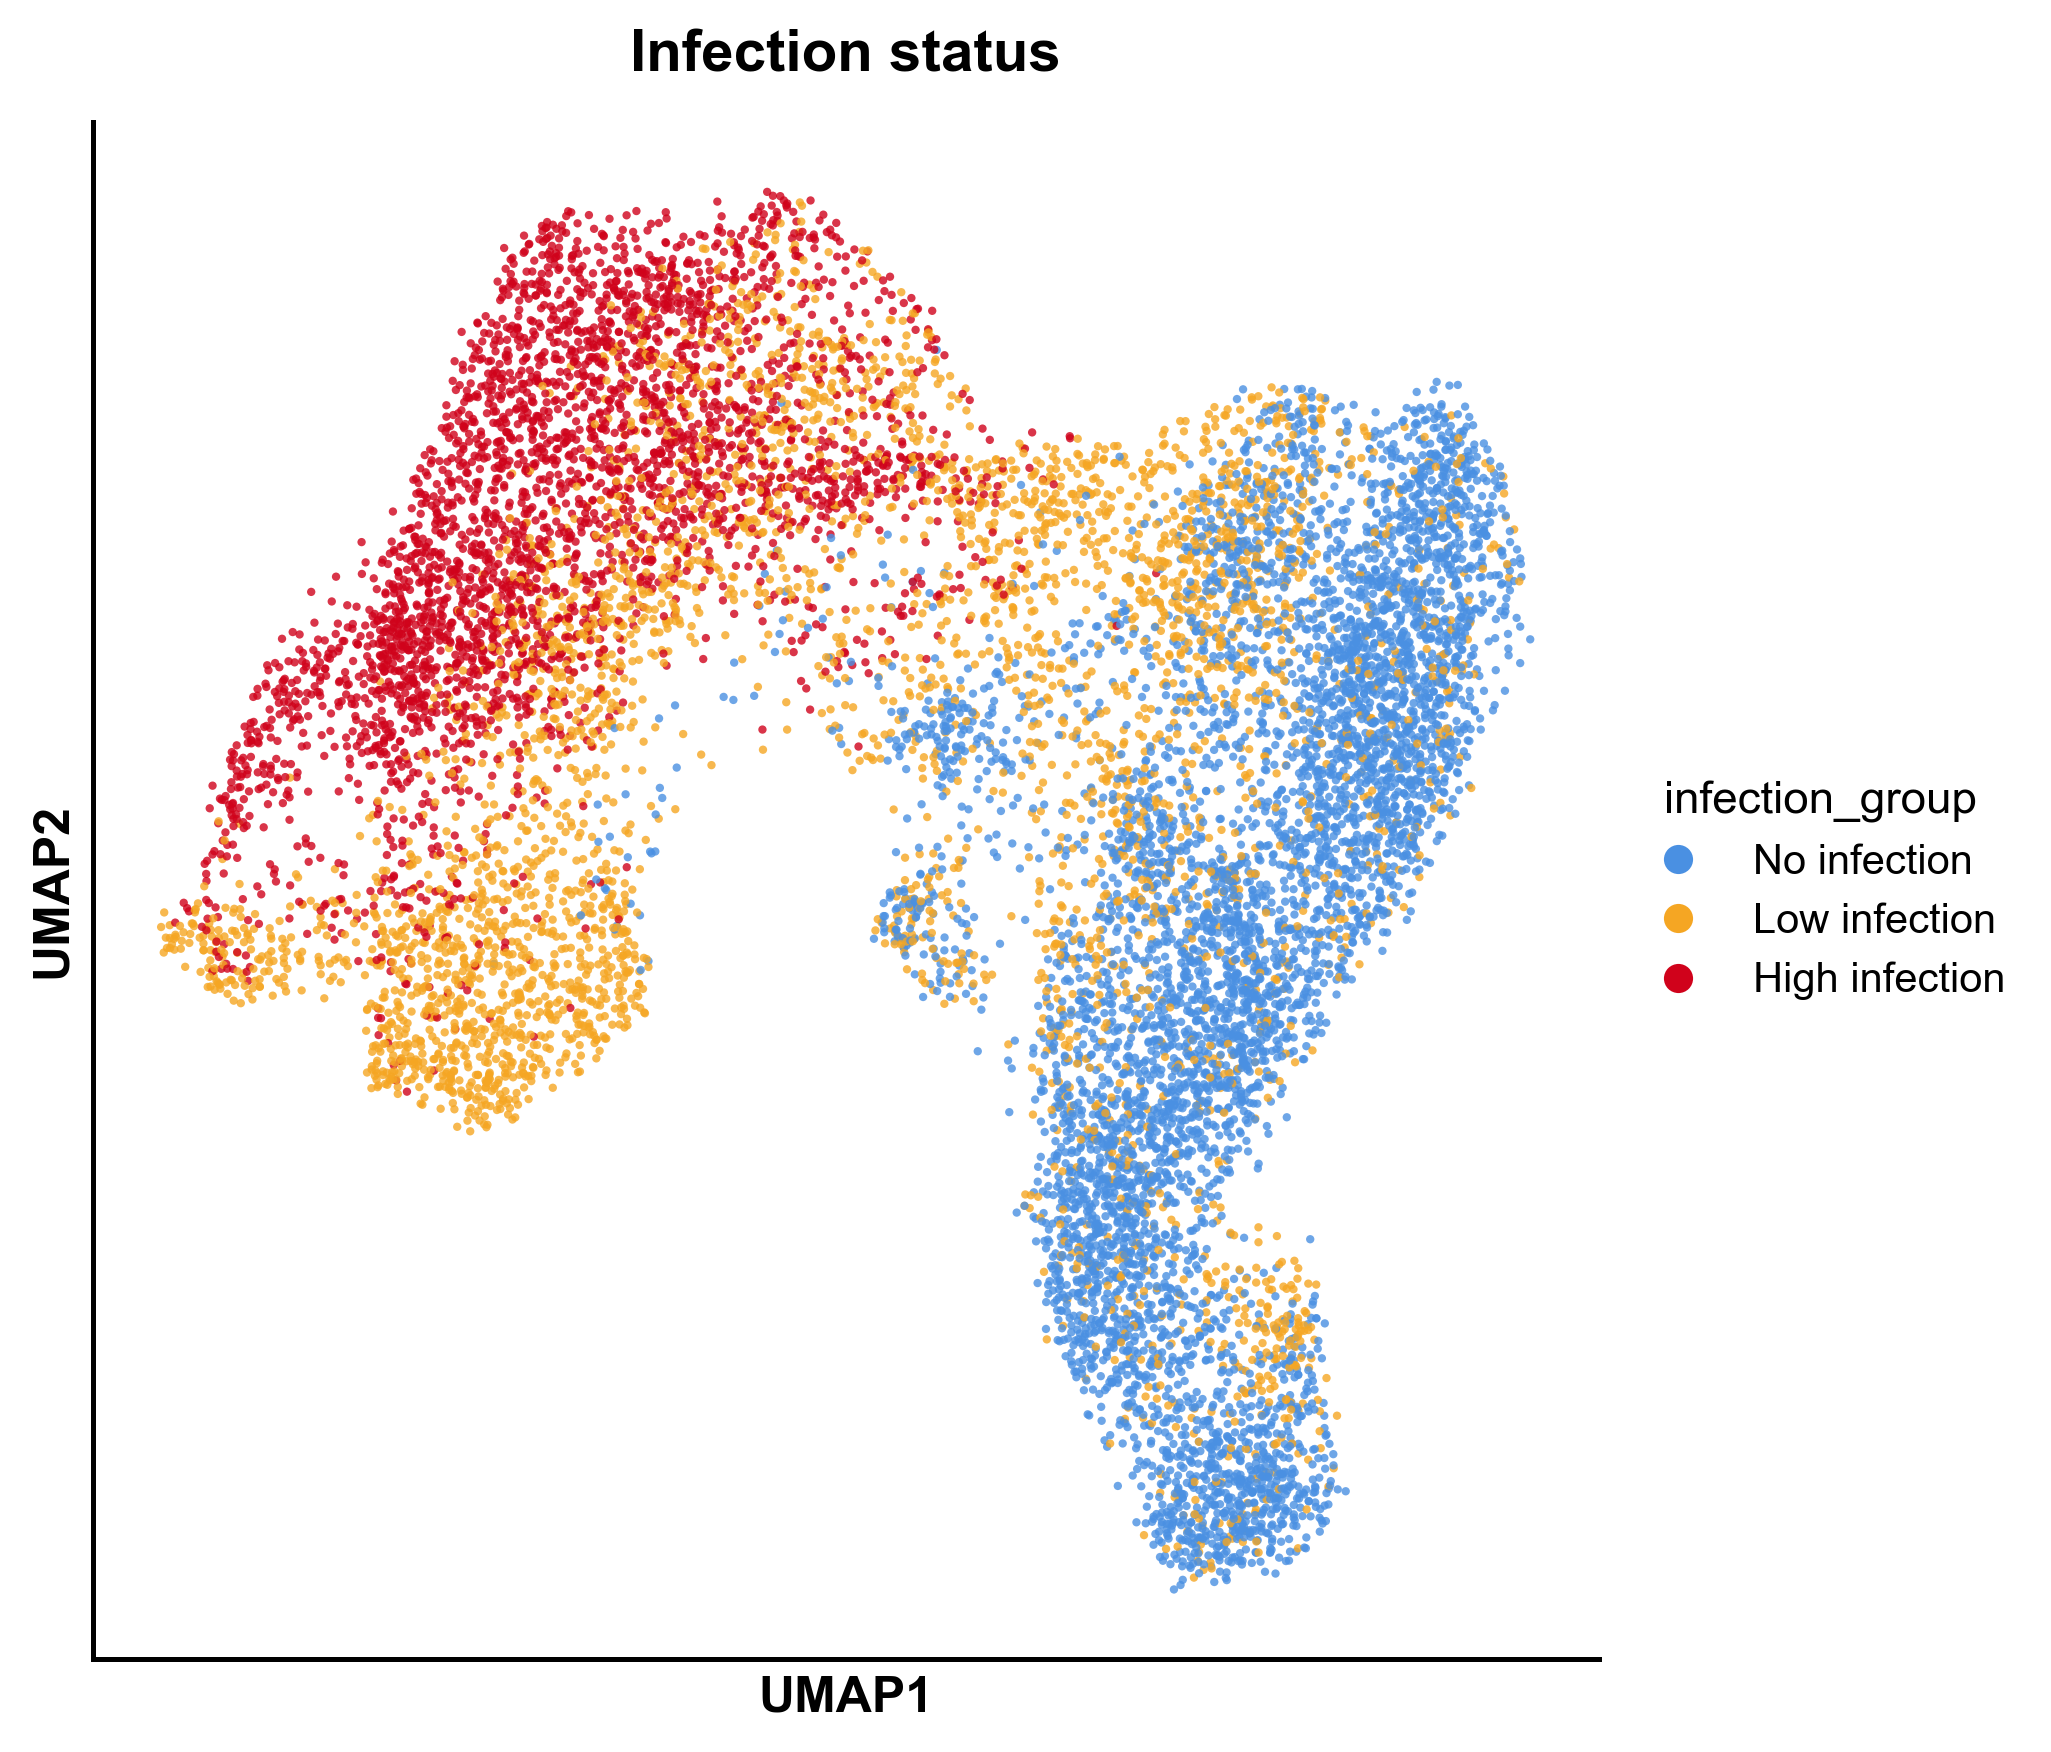

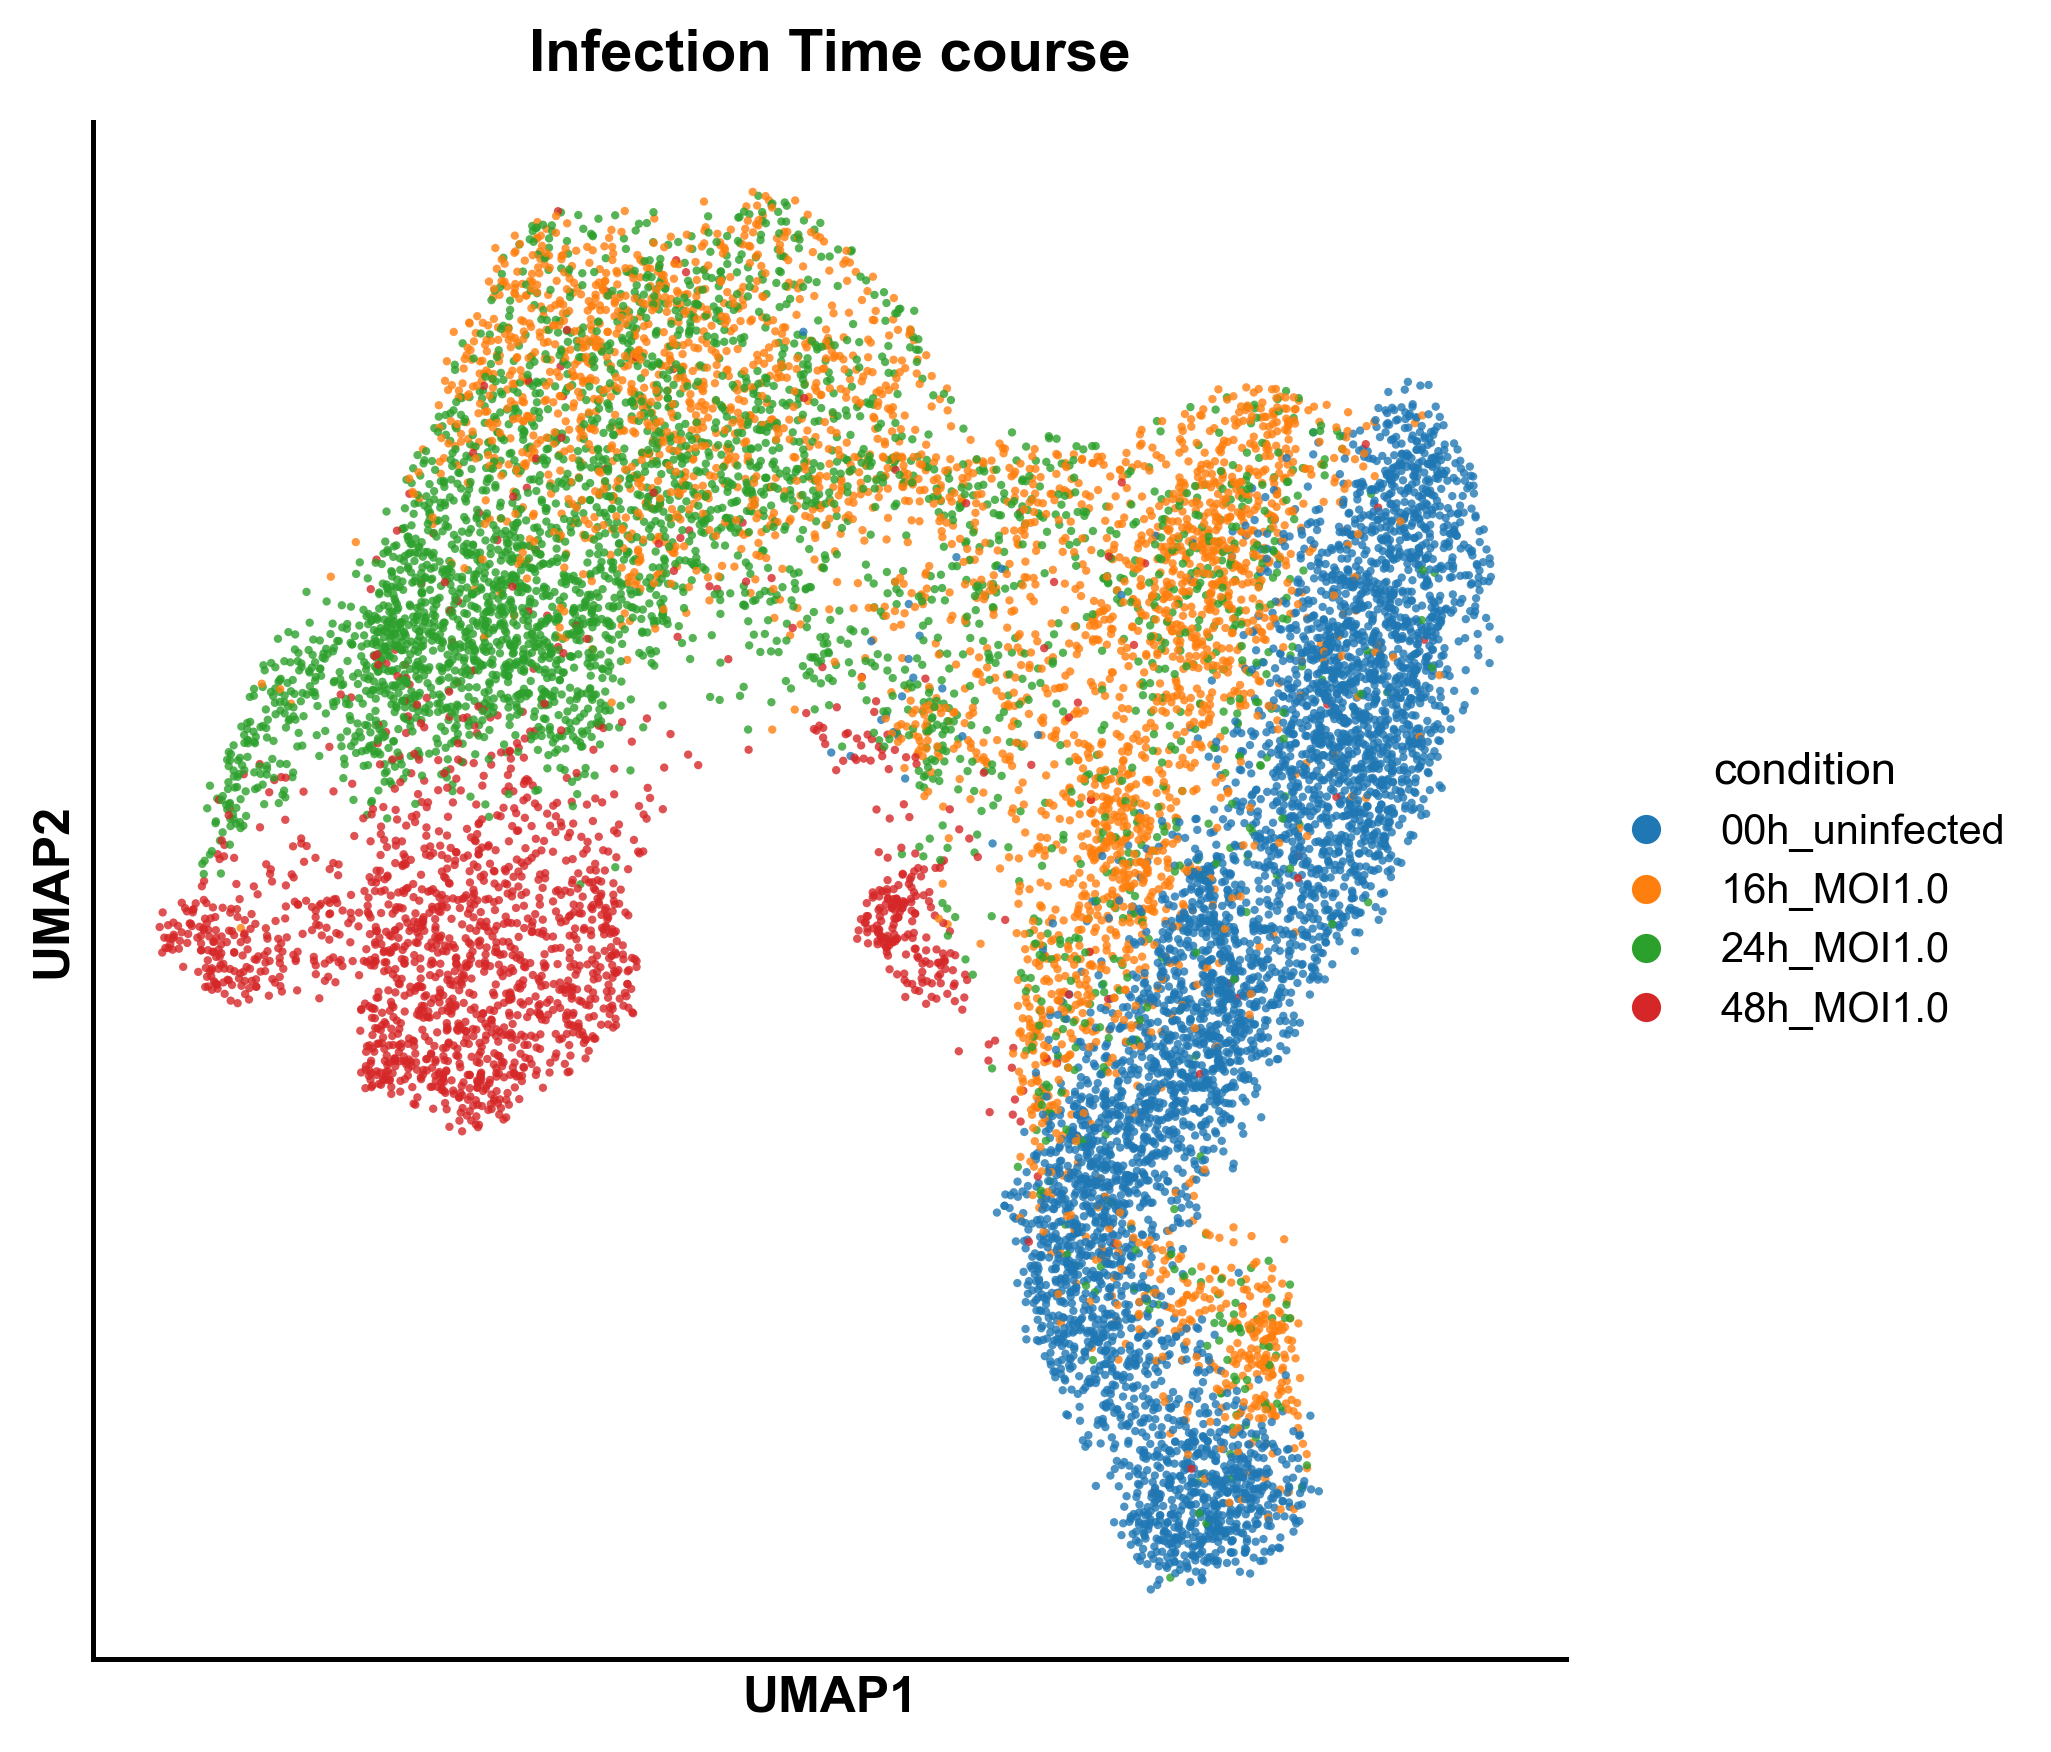

In [14]:
pl.set_publication_style()
pl.plot_umap_categorical(adata_hvg, color_var='infection_group', seed = 42, title= "Infection status",palette=category_colors, save_path='./Plot/Infection_group.png')
pl.plot_umap_categorical(adata_hvg, color_var='condition', seed = 42, title= "Infection Time course",palette=condition_palette, save_path='./Plot/Infection_teimcourse.png')

Continuous UMAP saved to: ./Plot/Fig1_Viral_Load.png


(<Figure size 2100x1800 with 2 Axes>,
 <Axes: title={'center': 'Viral Load(% OC43)'}, xlabel='UMAP1', ylabel='UMAP2'>)

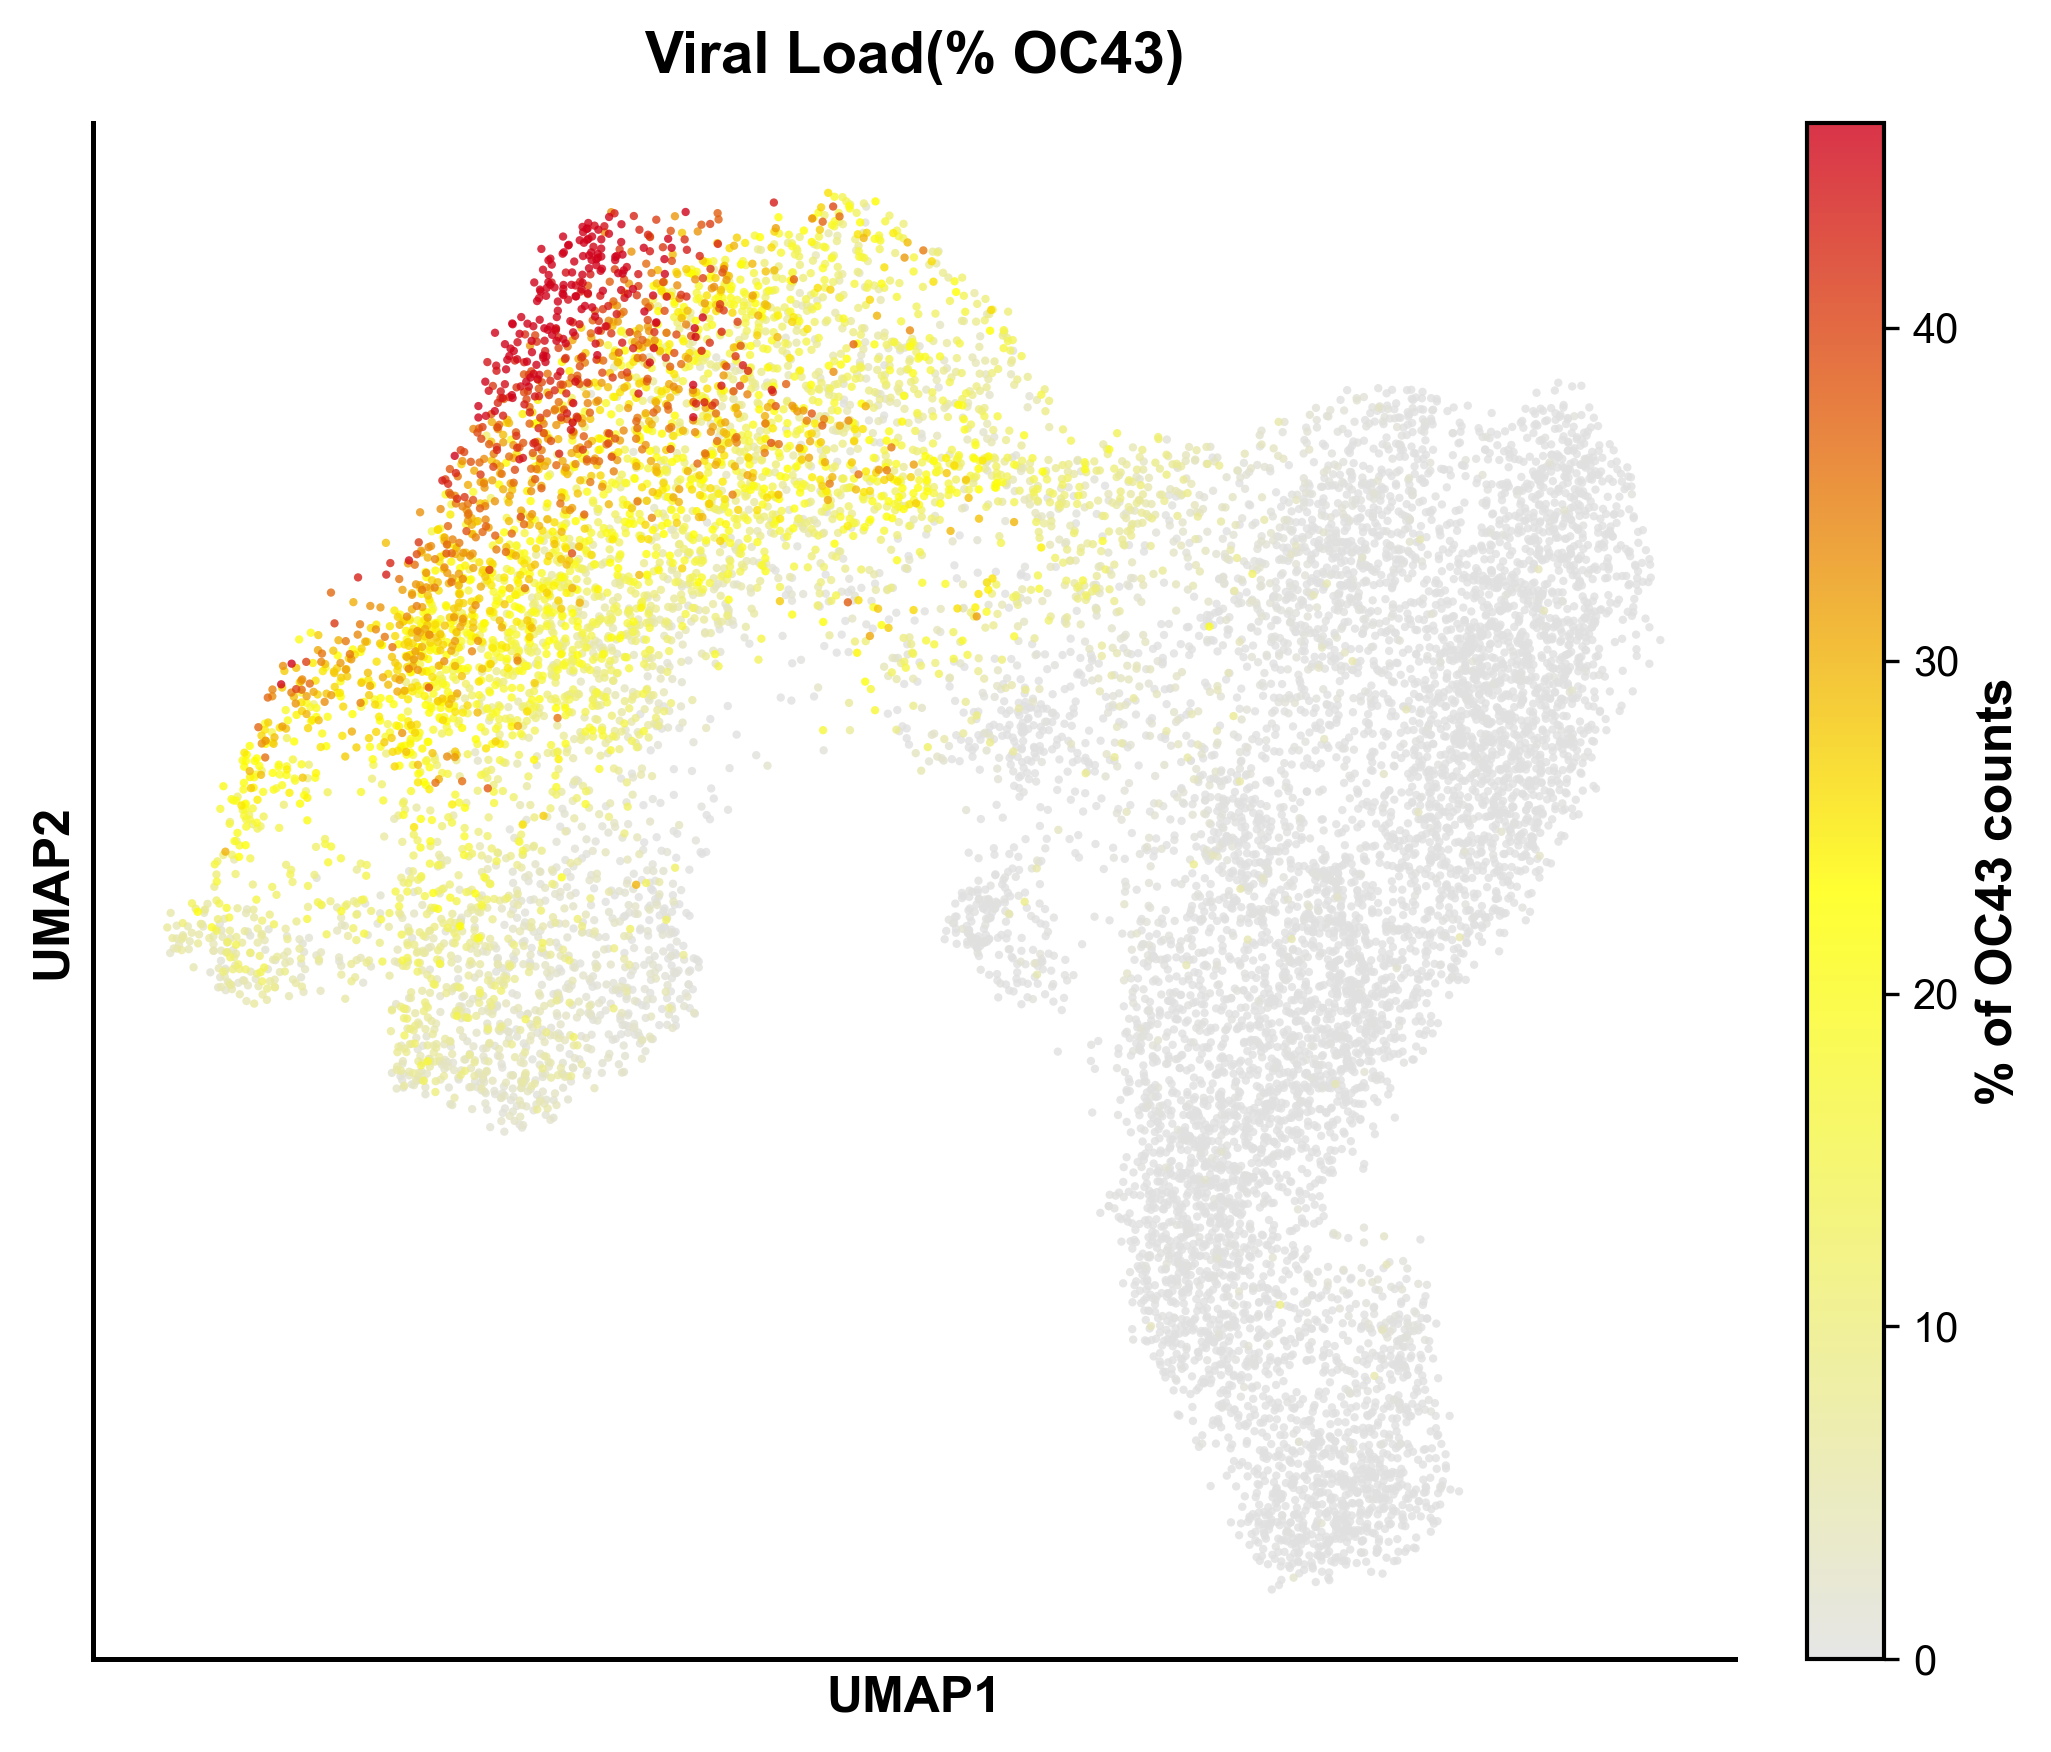

In [15]:
pl.plot_umap_continuous(adata_hvg, color_var='pct_counts_oc43', title = "Viral Load(% OC43)", save_path='./Plot/Fig1_Viral_Load.png')

In [16]:
genes_of_interest = [
    'RPS7', 'ACTB',  'PPIA', 'TPI1','ATP5MF','RPL23A','FTL','HES4', 'LDHA', 'IFRD1'
   ]

Gene expression plots saved to: ./Plot/Gene_expression_levels_by_infection_status.png


(<Figure size 2400x3600 with 12 Axes>,
 array([<Axes: title={'center': '(a) RPS7'}, xlabel='Infection Group', ylabel='Expression Level'>,
        <Axes: title={'center': '(b) ACTB'}, xlabel='Infection Group', ylabel='Expression Level'>,
        <Axes: title={'center': '(c) PPIA'}, xlabel='Infection Group', ylabel='Expression Level'>,
        <Axes: title={'center': '(d) TPI1'}, xlabel='Infection Group', ylabel='Expression Level'>,
        <Axes: title={'center': '(e) ATP5MF'}, xlabel='Infection Group', ylabel='Expression Level'>,
        <Axes: title={'center': '(f) RPL23A'}, xlabel='Infection Group', ylabel='Expression Level'>,
        <Axes: title={'center': '(g) FTL'}, xlabel='Infection Group', ylabel='Expression Level'>,
        <Axes: title={'center': '(h) HES4'}, xlabel='Infection Group', ylabel='Expression Level'>,
        <Axes: title={'center': '(i) LDHA'}, xlabel='Infection Group', ylabel='Expression Level'>,
        <Axes: title={'center': '(j) IFRD1'}, xlabel='Infection Gro

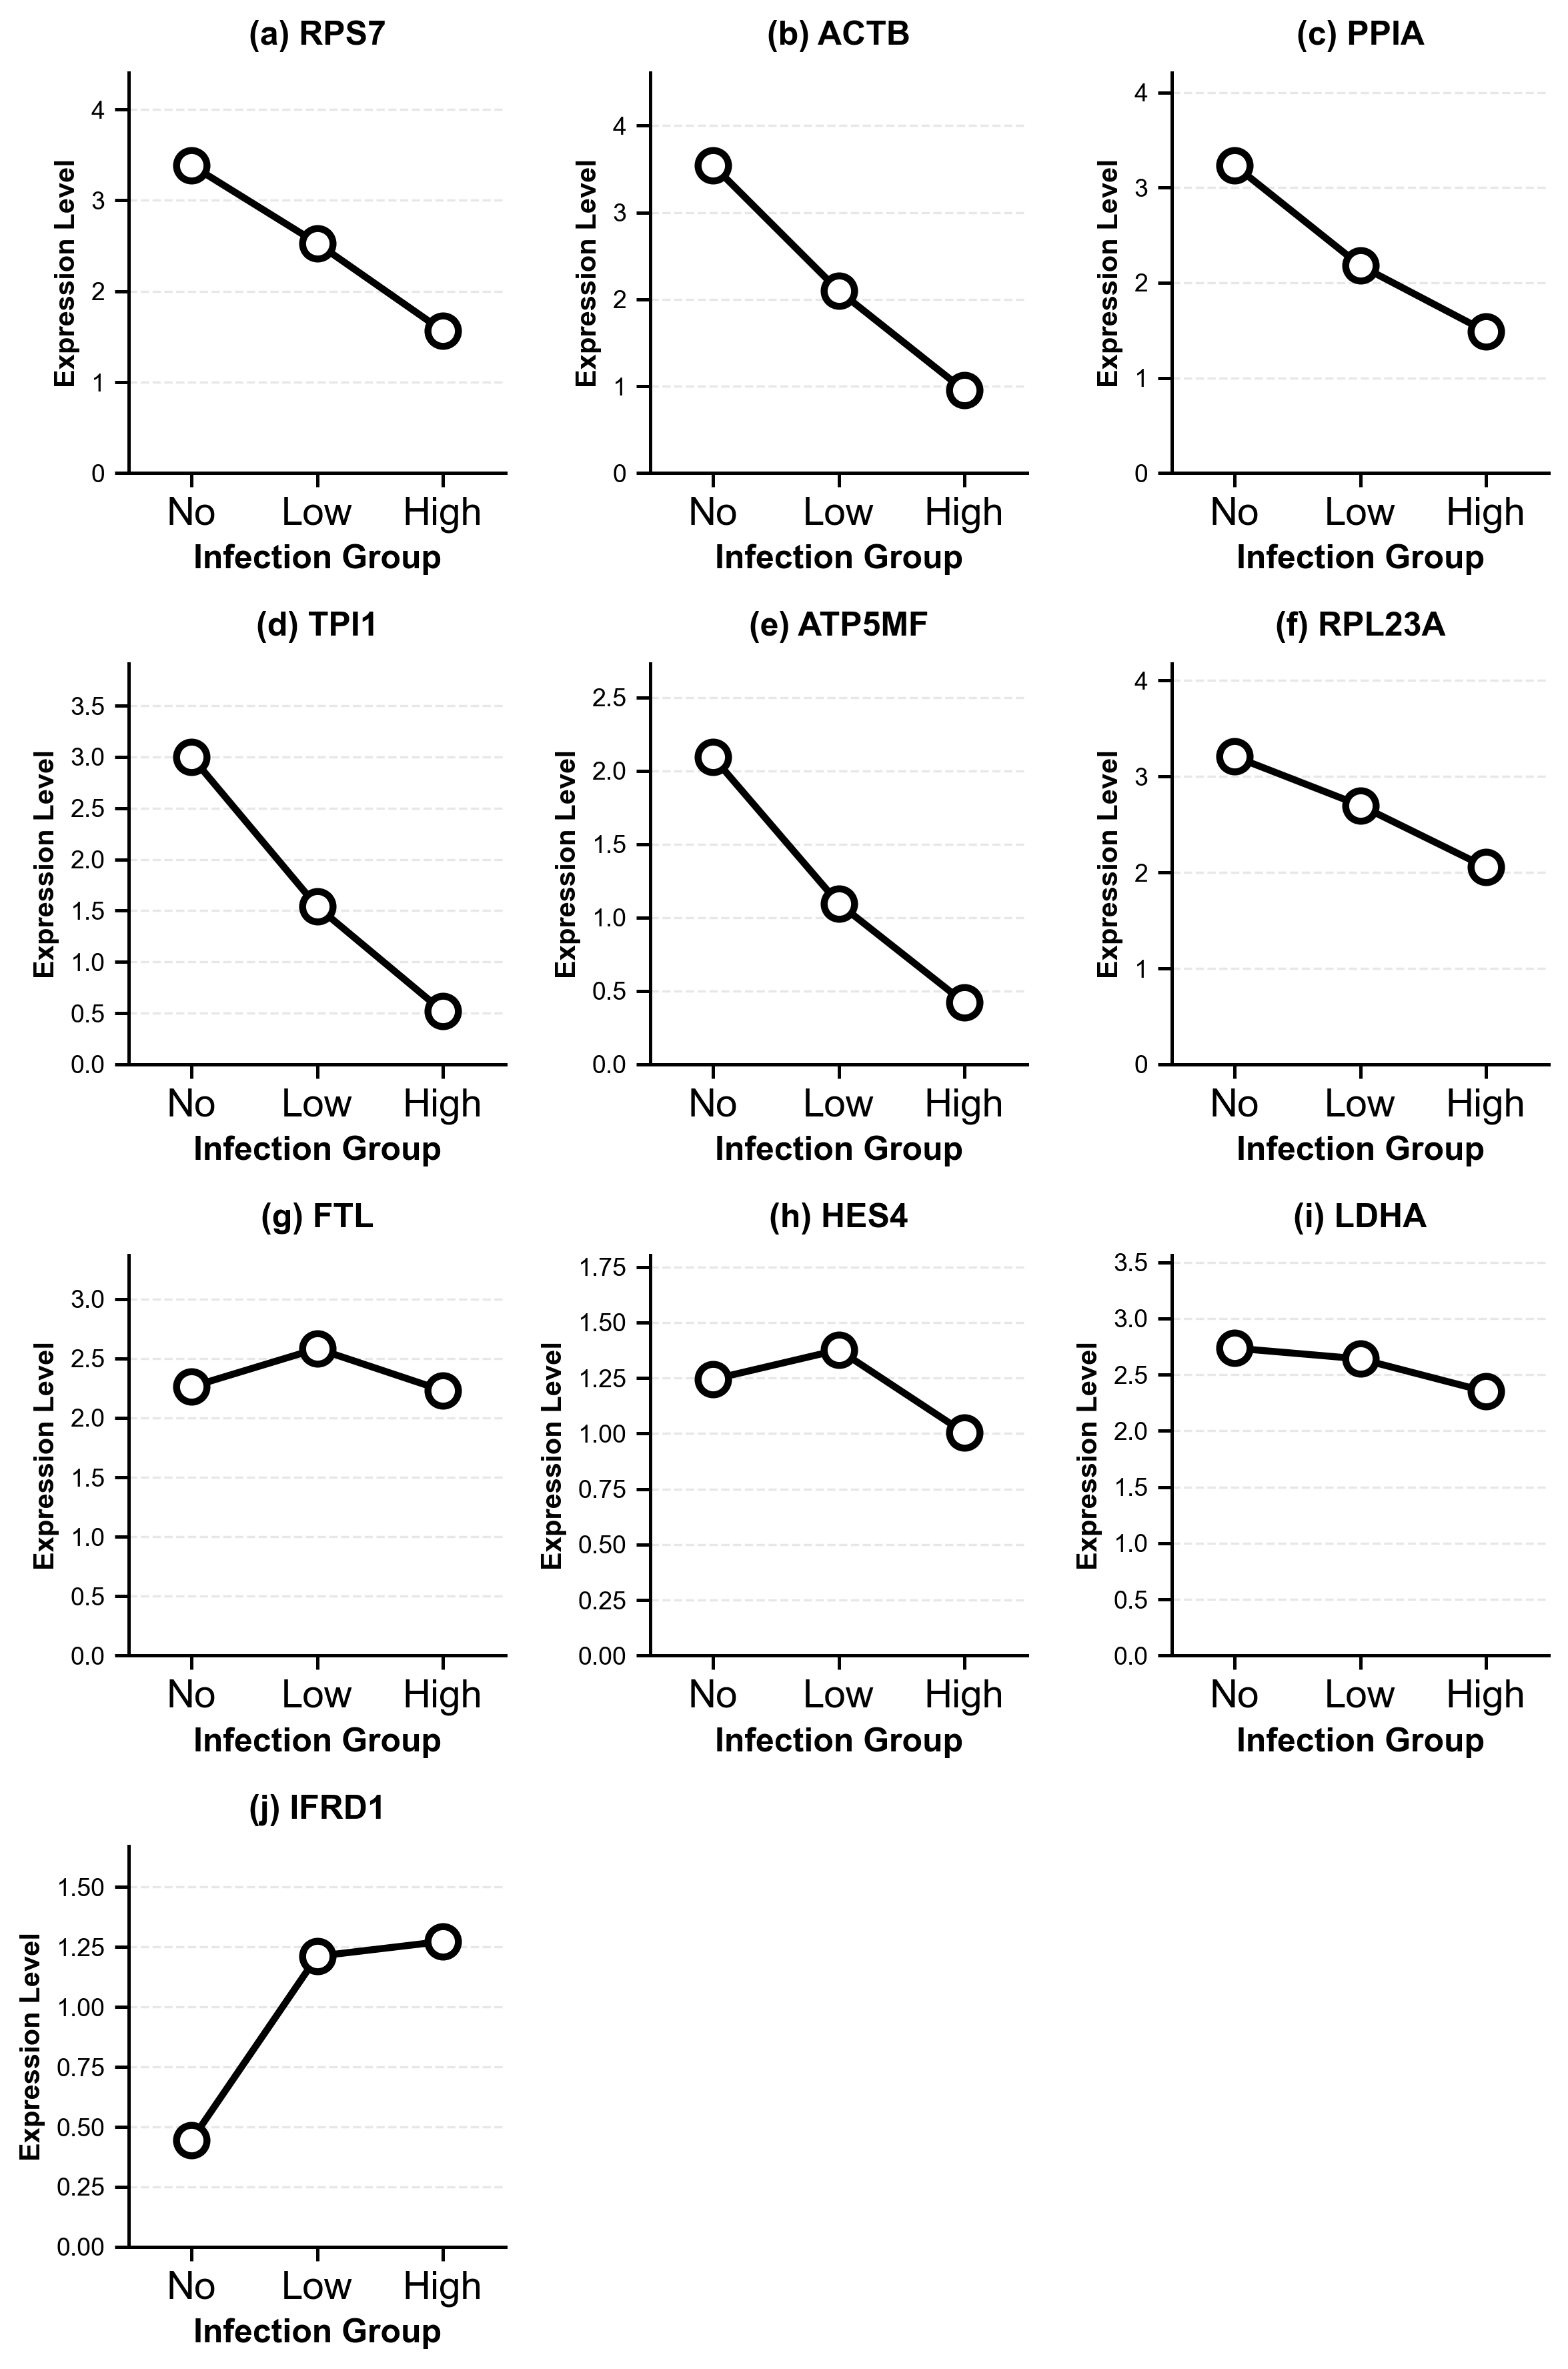

In [17]:
pl.plot_gene_expression_series(adata_hvg, 
    genes=genes_of_interest,
    group_key='infection_group',figsize=(8, 12), save_path= "./Plot/Gene_expression_levels_by_infection_status.png")

✅ Fixed DotPlot saved (No whitespace, labels intact)


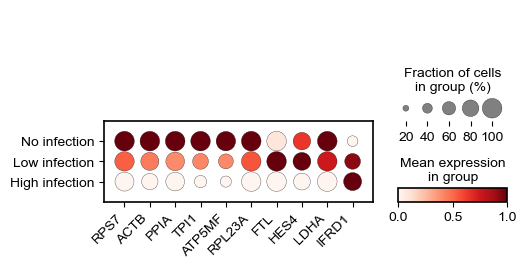

In [18]:
adata_hvg.obs['infection_group'] = adata_hvg.obs['infection_group'].astype('category')
adata_hvg.obs['infection_group'] = adata_hvg.obs['infection_group'].cat.reorder_categories(['No infection', 'Low infection', 'High infection'])

dp = sc.pl.dotplot(adata_hvg, var_names=genes_of_interest, groupby='infection_group', 
              standard_scale='var', 
              cmap='Reds', 
              categories_order=['No infection', 'Low infection', 'High infection'],
              show=False) 

ax = dp['mainplot_ax']
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.savefig('./Plot/_Fig2D_DotPlot.pdf', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.savefig('./Plot/_Fig2D_DotPlot.png', dpi=300, bbox_inches='tight', pad_inches=0.2)

print("✅ Fixed DotPlot saved (No whitespace, labels intact)")

C:\Users\yyyyx\Work\OC43_machine_learning\Regression_Modeling_of_OC43_Coronavirus_Viral_Burden_from_Host_Single-cell_Transcriptomes_Using_Explainable_Machine_Learning\scripts\plotting.py:258: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\yyyyx\Work\OC43_machine_learning\Regression_Modeling_of_OC43_Coronavirus_Viral_Burden_from_Host_Single-cell_Transcriptomes_Using_Explainable_Machine_Learning\scripts\plotting.py:258: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\yyyyx\Work\OC43_machine_learning\Regression_Modeling_of_OC43_Coronavirus_Viral_Burden_from_Host_Single-cell_Transcriptomes_Using_Explainable_Machine_Learning\scripts\plotting.py:258: FutureWarning: 

Passi

Overlay plots successfully saved to ./Plot/_Fig2C_ViolinPlot.png


(<Figure size 4200x2400 with 6 Axes>,
 array([<Axes: title={'center': 'IFRD1'}, ylabel='Log Expression'>,
        <Axes: title={'center': 'RPS7'}, ylabel='Log Expression'>,
        <Axes: title={'center': 'ACTB'}, ylabel='Log Expression'>,
        <Axes: title={'center': 'PPIA'}, ylabel='Log Expression'>,
        <Axes: title={'center': 'ATP5MF'}, ylabel='Log Expression'>,
        <Axes: title={'center': 'TPI1'}, ylabel='Log Expression'>],
       dtype=object))

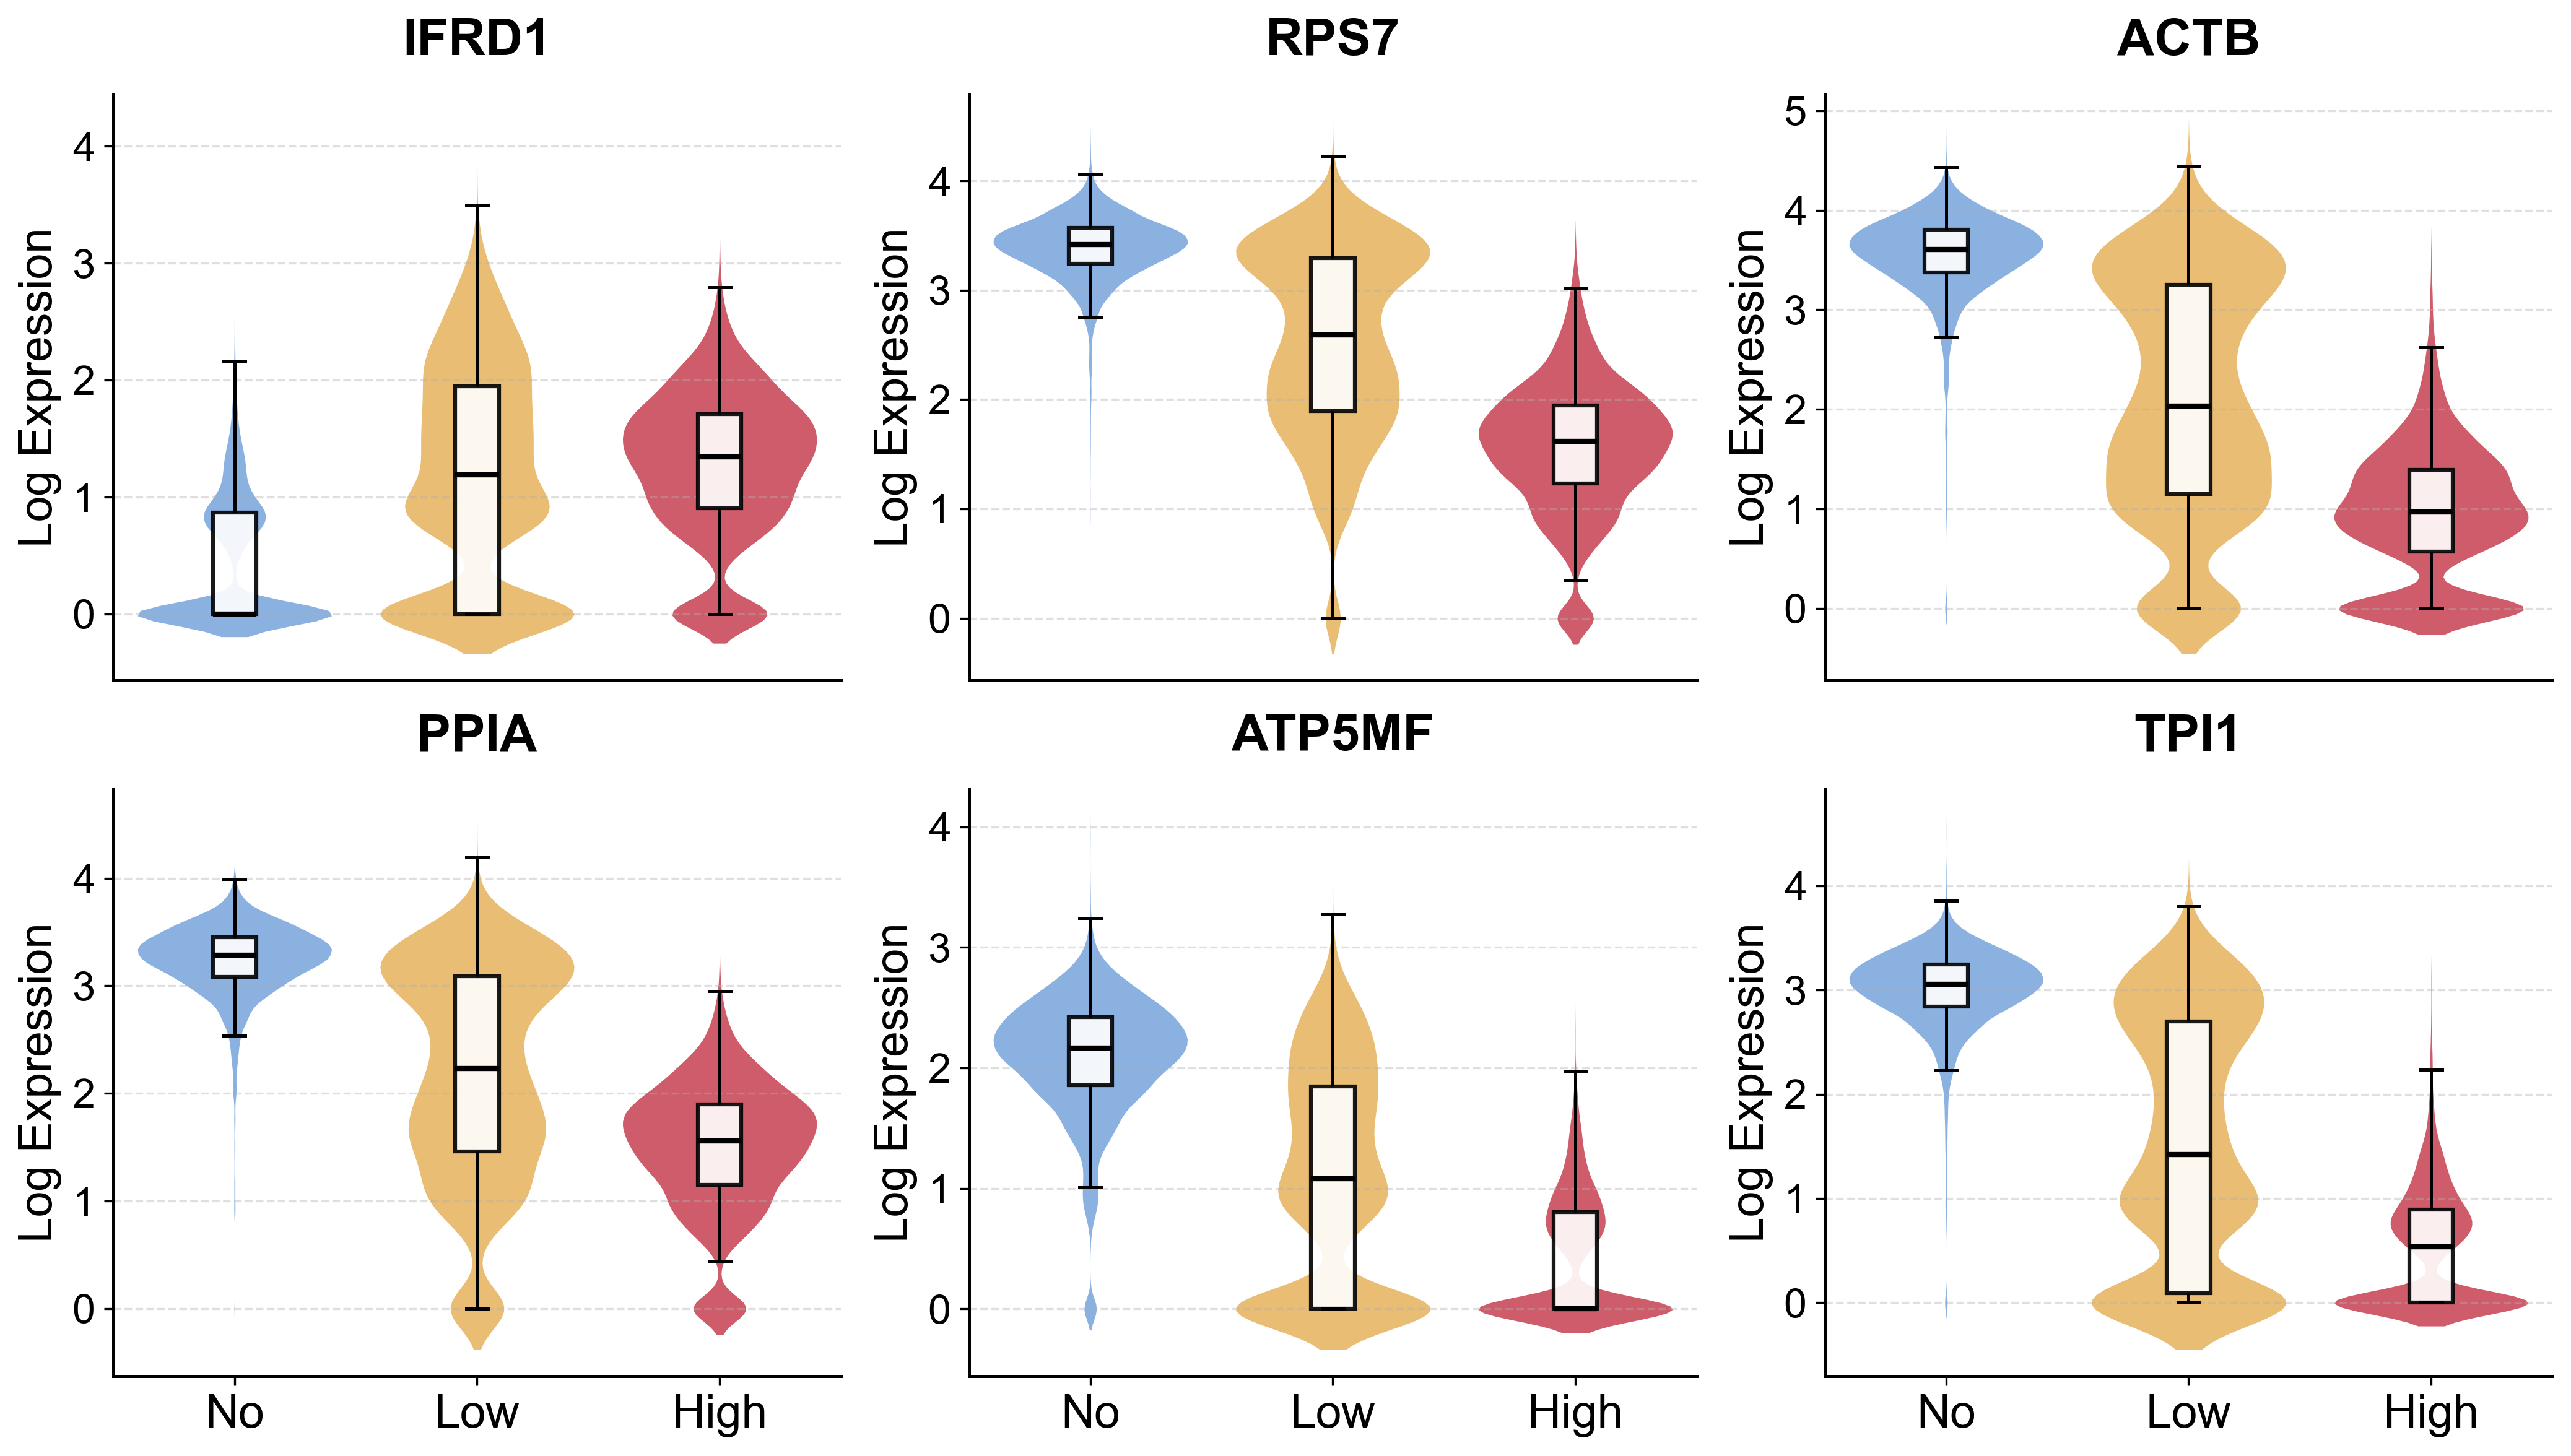

In [19]:
violin_palette = {
        'No infection': '#4A90E2', 
        'Low infection': '#F5A623', 
        'High infection': '#D0021B'
    }
target_genes = ['IFRD1', 'RPS7', 'ACTB', 'PPIA', 'ATP5MF', 'TPI1']
pl.plot_gene_violin_overlay(adata_hvg, target_genes, group_key='infection_group', 
                             order=['No infection', 'Low infection', 'High infection'], palette=violin_palette, figsize=(14,8), 
                             save_path='./Plot/_Fig2C_ViolinPlot.png')

In [20]:
anndata.settings.allow_write_nullable_strings = True
adata_hvg.write_h5ad('./Data/h5ad/Visualize.h5ad')

In [21]:
import session_info

session_info.show()